# Stage 3 — Cross-Cluster Link Behavior Analysis

We reuse the existing IVF-CE **Config B** index for both the centroid-only baseline
(`n2 = 0`, equivalent to IVF with `nprobe = B`) and the link-enabled variants (`n2 > 0`).
This isolates the impact of cross-cluster links without rebuilding a separate IVF index.

## Setup and configuration
Load dependencies, configure paths, and define all shared Stage 3 settings:
dataset, query selection, budgets `B`, fixed `k2`, the Config B index path, and the output log location.  
Also set `RUN_EVALUATIONS` to control whether diagnostics should be regenerated.

In [1]:
from __future__ import annotations

import json
import sys
from dataclasses import asdict
from pathlib import Path
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

repo_root = Path("/home/student/ivf-ce-ann")

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

sns.set_theme(style="whitegrid")

from data.dataset_loader import load_dataset
from experiments.utils import select_queries
from src.index.ivf_ce_index import IVFCEIndex
from src.search.ivf_ce_link_analysis import IVFCEExplorerDiagnostics, LinkDiagnostics

DATASET_NAME = "sift1m"
DATASET_ROOT = repo_root / "data"
QUERY_COUNT = 1000
QUERY_SEED = 0
K_VALUES = (10, 50, 100)
MAX_K = max(K_VALUES)
BUDGETS = (2, 3, 4, 5, 6, 8)
K2_FIXED = 100
CONFIG_B_INDEX = repo_root / "results/indexes/ivfce_sift1m_b_20251109.idx"
STAGE3_LOG_PATH = repo_root / "runs/stage3_link_analysis.jsonl"
RUN_EVALUATIONS = False  # Set True to regenerate diagnostics


## Load dataset and query slice

In [2]:
base_vectors, query_vectors, ground_truth = load_dataset(DATASET_NAME, DATASET_ROOT)
queries_subset, gt_subset = select_queries(
    query_vectors,
    ground_truth,
    QUERY_COUNT,
    seed=QUERY_SEED,
)
print(f"Base vectors: {base_vectors.shape}\nQueries used: {queries_subset.shape}")


Base vectors: (1000000, 128)
Queries used: (1000, 128)


## Load IVF-CE Config B index

In [16]:
if not CONFIG_B_INDEX.exists():
    raise FileNotFoundError(
        f"Missing IVF-CE Config B index at {CONFIG_B_INDEX}. Re-run Stage 1 to build it."
    )

ivfce_index = IVFCEIndex.load(CONFIG_B_INDEX)
print(
    f"Loaded IVF-CE Config B index | dim={ivfce_index.dimension}, clusters={ivfce_index.n_clusters}"
)


Loaded IVF-CE Config B index | dim=128, clusters=1024


## Helper utilities

In [17]:
def per_query_recall(gt_row: np.ndarray, preds: np.ndarray, k: int) -> float:
    limit = min(k, preds.shape[0], gt_row.shape[0])
    if limit == 0:
        return 0.0
    gt_set = set(gt_row[:limit])
    hits = sum(1 for candidate in preds[:limit] if candidate in gt_set)
    return hits / float(limit)


def serialize_diag(diag: LinkDiagnostics) -> dict:
    payload = asdict(diag)
    payload["link_recommended_clusters"] = list(payload["link_recommended_clusters"])
    payload["fallback_clusters"] = list(payload["fallback_clusters"])
    payload["nprobe_next_clusters"] = list(payload["nprobe_next_clusters"])
    return payload


def evaluate_configuration(*, B: int, n1: int, n2: int, method_label: str) -> list[dict]:
    explorer = IVFCEExplorerDiagnostics(
        ivfce_index,
        n1=n1,
        n2=n2,
        k2=K2_FIXED,
    )
    rows: list[dict] = []
    for qid, (query, gt_row) in enumerate(zip(queries_subset, gt_subset)):
        q_start = perf_counter()
        ids, _dists, diag = explorer.search_with_diagnostics(
            query,
            MAX_K,
            query_id=qid,
            B=B,
        )
        latency_ms = (perf_counter() - q_start) * 1e3
        rec_dict = {
            f"recall_at_{k}": per_query_recall(gt_row, ids, k) for k in K_VALUES
        }
        row = {
            "method": method_label,
            "config_name": "B",
            "B": B,
            "n1": n1,
            "n2": n2,
            "k2": K2_FIXED if n2 > 0 else None,
            "query_id": qid,
            "latency_ms": latency_ms,
            "avg_query_time_ms": latency_ms,
            "timestamp": None,
        }
        row.update(rec_dict)
        row.update(serialize_diag(diag))
        rows.append(row)
    return rows


## Run Stage 3 instrumentation (set `RUN_EVALUATIONS=True` to execute)
This step generates **per-query diagnostics** for all budgets `B`, covering both:
- **Baseline mode** (`n2 = 0`): centroid-only probing (IVF-style search using the same index)
- **Link-enabled mode** (`n2 > 0`): IVF-CE searches with cross-cluster link exploration

For every query, the following are logged:
- Recall@10/50/100  
- Latency  
- Number of link-based vs fallback clusters used  
- The actual IDs of recommended link clusters and fallback clusters  
- The IVF “next centroid” candidates for overlap comparison  
- The overlap rate between link clusters and normal IVF probes  

All diagnostics are written to `stage3_link_analysis.jsonl` when `RUN_EVALUATIONS=True`.  
If disabled, the notebook simply loads the existing log for analysis.

In [18]:
if RUN_EVALUATIONS:
    all_rows: list[dict] = []
    for B in BUDGETS:
        # Baseline: n2 = 0 (centroid-only search on the IVF-CE index)
        all_rows.extend(
            evaluate_configuration(B=B, n1=B, n2=0, method_label="ivf_baseline")
        )
        # Link-enabled splits.
        for n2 in range(1, B):
            n1 = B - n2
            all_rows.extend(
                evaluate_configuration(B=B, n1=n1, n2=n2, method_label="ivf_ce")
            )
    STAGE3_LOG_PATH.parent.mkdir(parents=True, exist_ok=True)
    with STAGE3_LOG_PATH.open("w", encoding="utf-8") as handle:
        for row in all_rows:
            row = {**row, "timestamp": row.get("timestamp") or None}
            handle.write(json.dumps(row) + "\n")
    print(f"Wrote {len(all_rows)} rows to {STAGE3_LOG_PATH}")
else:
    if STAGE3_LOG_PATH.exists():
        print(
            "RUN_EVALUATIONS is False; loading existing log for analysis: "
            f"{STAGE3_LOG_PATH}"
        )
    else:
        print("Stage 3 log missing. Set RUN_EVALUATIONS=True and rerun this cell.")


Wrote 28000 rows to /home/student/ivf-ce-ann/runs/stage3_link_analysis.jsonl


## Load Stage 3 results

In [19]:
if not STAGE3_LOG_PATH.exists():
    raise FileNotFoundError(
        f"Stage 3 log not found at {STAGE3_LOG_PATH}. Run the instrumentation cell first."
    )

link_df = pd.read_json(STAGE3_LOG_PATH, lines=True)
print(f"Loaded {len(link_df)} rows of per-query diagnostics.")
link_df.head()


Loaded 28000 rows of per-query diagnostics.


,method,config_name,B,n1,n2,k2,query_id,latency_ms,avg_query_time_ms,timestamp,recall_at_10,recall_at_50,recall_at_100,link_clusters_used,fallback_clusters_used,n2_total,link_recommended_clusters,fallback_clusters,nprobe_next_clusters,overlap_rate
0,ivf_baseline,B,2,2,0,NaN,0,4.580551,4.580551,NaT,0.5,0.52,0.53,0,0,0,[],[],[],0.0
1,ivf_baseline,B,2,2,0,NaN,1,4.241862,4.241862,NaT,0.4,0.34,0.38,0,0,0,[],[],[],0.0
2,ivf_baseline,B,2,2,0,NaN,2,3.227495,3.227495,NaT,0.4,0.34,0.29,0,0,0,[],[],[],0.0
3,ivf_baseline,B,2,2,0,NaN,3,3.701779,3.701779,NaT,0.9,0.86,0.77,0,0,0,[],[],[],0.0
4,ivf_baseline,B,2,2,0,NaN,4,3.035501,3.035501,NaT,0.1,0.16,0.11,0,0,0,[],[],[],0.0


## Aggregate link vs fallback usage
Compute, for each `(B, n1, n2)` configuration with `n2 > 0`, the average number of clusters
opened via cross-links vs fallback, along with the average `n2_total`.

In [20]:
usage = (
    link_df[(link_df["method"] == "ivf_ce") & (link_df["n2"] > 0)]
    .groupby(["B", "n1", "n2"])
    .agg({
        "link_clusters_used": "mean",
        "fallback_clusters_used": "mean",
        "n2_total": "mean",
    })
    .reset_index()
)
usage


,B,n1,n2,link_clusters_used,fallback_clusters_used,n2_total
0,2,1,1,1.000,0.000,1.0
1,3,1,2,2.000,0.000,2.0
2,3,2,1,1.000,0.000,1.0
3,4,1,3,3.000,0.000,3.0
4,4,2,2,1.998,0.002,2.0
5,4,3,1,0.998,0.002,1.0
6,5,1,4,3.998,0.002,4.0
7,5,2,3,2.995,0.005,3.0
8,5,3,2,1.994,0.006,2.0
9,5,4,1,0.996,0.004,1.0


## Overlap rate for B = 6
For budget `B = 6`, compute how often the link-recommended clusters overlap with the
next-centroid clusters that standard IVF would have probed.  
We average the overlap rate per `n2` to see how this behavior changes as more
Stage-2 clusters are allocated.

In [ ]:
overlap = (
    link_df[(link_df["method"] == "ivf_ce") & (link_df["B"] == 6) & (link_df["n2"] > 0)]
    .groupby("n2")
    .overlap_rate.mean()
    .reset_index()
    .sort_values("n2")
)
overlap


,n2,overlap_rate
0,1,0.125000
1,2,0.219500
2,3,0.276667
3,4,0.317500
4,5,0.344200


## Recall impact of enabling cross-cluster links (`n2 = 1`)
Compute the average recall for:
- the **baseline** (`n2 = 0`, centroid-only), and  
- the **link-enabled case** (`n2 = 1`)  

for each budget `B`.  
We then take the difference to measure how much recall improves (or not) when a
single linked cluster is added on top of standard IVF behavior.

In [22]:
def average_recall(df: pd.DataFrame, method_label: str, *, n2_value: int) -> pd.DataFrame:
    subset = df[(df["method"] == method_label) & (df["n2"] == n2_value)]
    return (
        subset.groupby("B")[['recall_at_10', 'recall_at_50', 'recall_at_100']]
        .mean()
        .reset_index()
    )

baseline_avg = average_recall(link_df, "ivf_baseline", n2_value=0)
ce_n2_1 = average_recall(link_df, "ivf_ce", n2_value=1)
recall_delta = ce_n2_1.set_index("B") - baseline_avg.set_index("B")
recall_delta = recall_delta.reset_index()
recall_delta


,B,recall_at_10,recall_at_50,recall_at_100
0,2,-0.1040,-0.08668,-0.07935
1,3,-0.0532,-0.04776,-0.04494
2,4,-0.0311,-0.02926,-0.02679
3,5,-0.0195,-0.02048,-0.01964
4,6,-0.0160,-0.01402,-0.01305
5,8,-0.0064,-0.00586,-0.00613


## Plot 1 — Link vs fallback usage across budgets
Visualize how the Stage-2 cluster budget is actually spent for IVF-CE runs (`n2 > 0`):
- **Link**: clusters opened via cross-cluster recommendations  
- **Fallback**: clusters opened via standard centroid probing when no link is available  

Bars are grouped by `(B, n2)` to show how the split between link and fallback changes as
we vary the Stage-2 allocation within each total budget.

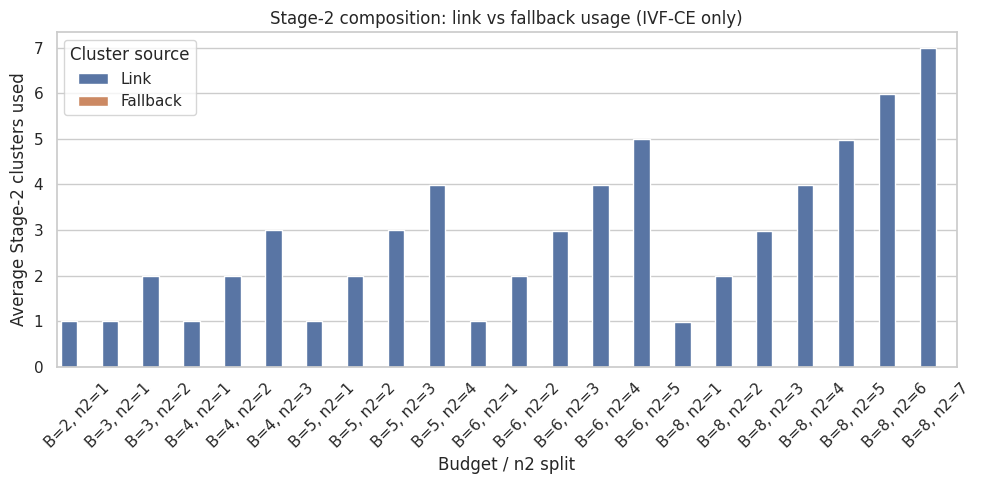

In [27]:
if usage.empty:
    print("No IVF-CE rows available.")
else:
    usage_sorted = usage.sort_values(["B", "n2"]).reset_index(drop=True)
    usage_long = usage_sorted.melt(
        id_vars=["B", "n1", "n2"],
        value_vars=["link_clusters_used", "fallback_clusters_used"],
        var_name="cluster_source",
        value_name="avg_clusters",
    )
    usage_long["cluster_source"] = usage_long["cluster_source"].map(
        {
            "link_clusters_used": "Link",
            "fallback_clusters_used": "Fallback",
        }
    )
    usage_long["label"] = usage_long.apply(
        lambda row: f"B={int(row['B'])}, n2={int(row['n2'])}", axis=1
    )

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        data=usage_long,
        x="label",
        y="avg_clusters",
        hue="cluster_source",
        ax=ax,
    )
    ax.set_xlabel("Budget / n2 split")
    ax.set_ylabel("Average Stage-2 clusters used")
    ax.set_title("Stage-2 composition: link vs fallback usage (IVF-CE only)")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Cluster source")
    plt.tight_layout()
    plt.show()


## Plot 2 — Recall gain from enabling a single cross-link hop
For each budget `B`, we compare the baseline (`n2 = 0`) to the link-enabled case (`n2 = 1`)
and plot the change in `Recall@10`:

- Positive values → using one linked cluster improves recall  
- Zero or negative values → links provide little or no benefit for that budget  

This highlights the direct impact of adding a single cross-cluster exploration step.

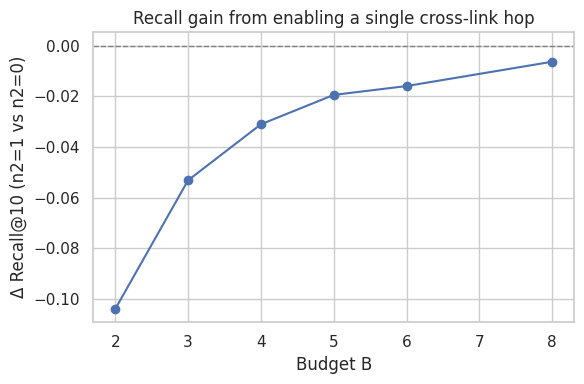

In [25]:
if recall_delta.empty:
    print("Recall delta data unavailable.")
else:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(recall_delta["B"], recall_delta["recall_at_10"], marker="o")
    ax.axhline(0.0, color="gray", linestyle="--", linewidth=1)
    ax.set_xlabel("Budget B")
    ax.set_ylabel("Δ Recall@10 (n2=1 vs n2=0)")
    ax.set_title("Recall gain from enabling a single cross-link hop")
    plt.tight_layout()
    plt.show()


## Plot 3 — Overlap between link recommendations and IVF centroids (B = 6)
For `B = 6`, we measure how often the clusters recommended by cross-links
match the next-centroid clusters that standard IVF would have probed.

- **X-axis:** `n2` (number of Stage-2 clusters explored)  
- **Y-axis:** mean overlap rate (%)  

This shows how frequently link-based exploration duplicates what IVF would have done anyway.

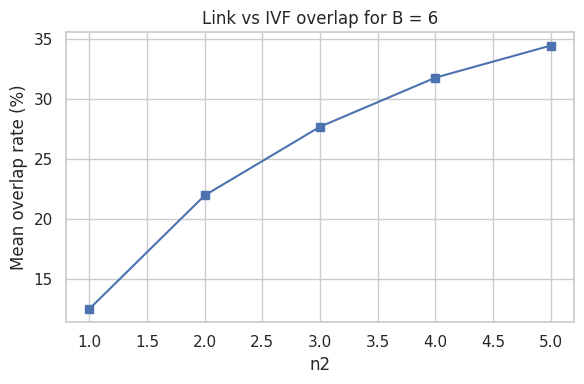

In [26]:
if overlap.empty:
    print("No overlap data for B = 6.")
else:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(overlap["n2"], overlap["overlap_rate"] * 100, marker="s")
    ax.set_xlabel("n2")
    ax.set_ylabel("Mean overlap rate (%)")
    ax.set_title("Link vs IVF overlap for B = 6")
    plt.tight_layout()
    plt.show()
